# Import libraries

In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt
#----------------------------
# scikit-learn
#----------------------------
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# neural network
from sklearn.neural_network import MLPClassifier
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
#use numpy fixed point notation
np.set_printoptions(suppress=True)
#----------------------------
# disable convergence warning
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
#----------------------------
# path to save figures
path = '../figures/mlp/'

# Reading the dataset (.mat file)

In [3]:
from os.path import abspath, join
# get the root dir ('current_dir/..')
root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')

In [4]:
# set dataset files path
training_file = join(dataset_dir, 'dados_treinamento.mat')
validation_file = join(dataset_dir, 'dados_val.mat')
test_file = join(dataset_dir, 'dados_teste.mat')

In [5]:
# read mat files
training = sio.loadmat(training_file)
validation = sio.loadmat(validation_file)
test = sio.loadmat(test_file)

## Training, validation and test sets

In [6]:
# training set
X_raw = training['X']
y_raw = training['y']
y = y_raw.flatten()
#----------------------------
# validation set
Xval_raw = validation['Xval']
yval_raw = validation['yval']
yval = yval_raw.flatten()
#----------------------------
# test set
Xt_raw = test['Xt']
yt_raw = test['yt']
yt = yt_raw.flatten()

# Preprocessing the data

In [7]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
# fit only on training + validation set
scaler.fit(X_raw + Xval_raw)
# perform standardization with x data
X = scaler.transform(X_raw)
Xval = scaler.transform(Xval_raw)
# apply same transformation to test data
Xt = scaler.transform(Xt_raw)

## Adjusting labels to 0 or 1

In [8]:
y = (y + 1) / 2
yval = (yval + 1) / 2
yt = (yt + 1) / 2

# Data Visualization

## Plotting the result of classification

In [9]:
def plot_data(X, y, alpha=1):
    # prepare date
    x1 = X[:,0]
    x2 = X[:,1]
    y = y.flatten()
    # create dataframe
    df = pd.DataFrame(data={'x1': x1, 'x2': x2, 'label': y})
    # dataframe of positive and negative class
    PC = df.loc[df['label'] == 1]
    NC = df.loc[df['label'] == 0]
    # plot points
    #plt.cla() # clear axis
    #plt.clf() # clear figure
    #ax = PC.plot(kind='scatter', x='x1', y='x2', color='blue', marker='.')
    #NC.plot(ax=ax, grid=True, kind='scatter', x='x1', y='x2', color='red', marker='.')
    ax1 = PC.plot(kind='scatter', x='x1', y='x2', alpha=alpha, color='blue', marker='.')
    ax2 = NC.plot(ax=ax1, grid=True, kind='scatter', x='x1', y='x2', alpha=alpha, color='red', marker='.')
    return ax2

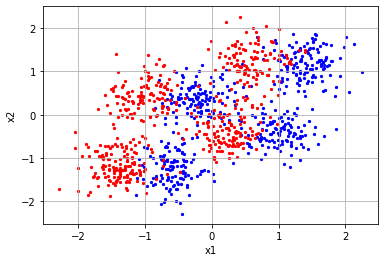

In [10]:
plot_data(X_raw, y)
plt.savefig(path + 'raw_data.png', dpi=300)

## Plotting the decision regions

In [11]:
def plot_decision_regions(X, model):
    # split X in x1 and x2
    x1 = X[:, 0]
    x2 = X[:, 1]
    # define grid limits for x1 and x2
    x1_min = x1.min() - 0.25
    x1_max = x1.max() + 0.25
    x2_min = x2.min() - 0.25
    x2_max = x2.max() + 0.25
    #----------------------------
    # create grid
    #steps = 4096
    step = 0.01
    #x1_span = np.linspace(x1_min, x1_max, steps)
    #x2_span = np.linspace(x2_min, x2_max, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    x1_span = np.arange(x1_min, x1_max, step)
    x2_span = np.arange(x2_min, x2_max, step)
    xx1, xx2 = np.meshgrid(x1_span, x2_span)
    # convert to 1-D array and concatenate them
    xx1_f = xx1.flatten()
    xx2_f = xx2.flatten()
    points = np.c_[xx1_f, xx2_f]
    #----------------------------
    # plot decision regions
    y = model.predict(points)
    y = y.reshape(xx1.shape)
    ax = plt.contourf(xx1, xx2, y, cmap=plt.cm.Spectral)
    return ax

# Multi-layer Perceptron Classifier

In [12]:
@ignore_warnings(category=ConvergenceWarning)
def iterate(X, y, Xval, yval, model):
    model.fit(X, y)
    # training loss
    training_loss = log_loss(y, mlp.predict(X))
    # validation loss
    validation_loss = log_loss(yval, mlp.predict(Xval))
    return training_loss, validation_loss

## Model parameters

In [13]:
units=50
mlp = MLPClassifier(
    hidden_layer_sizes=(units,),
    activation='relu',
    #activation='logistic',
    #activation='tanh',
    #solver='sgd',
    #solver='lbfgs',
    solver='adam',
    alpha=0.01,
    batch_size=200,
    #learning_rate='constant',
    learning_rate_init=0.01,
    random_state=42,
    tol=1e-3,
    #verbose=True,
    warm_start = True,
    #warm_start = False,
    #max_iter=100,
    max_iter=1,
    #---------------------
    # adam
    beta_1 =0.9,
    beta_2 = 0.95,
    epsilon = 1e-8,
    n_iter_no_change = 10,
)
parameters = mlp.get_params()

In [14]:
training_loss = []
validation_loss = []

In [15]:
for i in range(1500):
    loss = iterate(X, y, Xval, yval, mlp)
    training_loss.append(loss[0])
    validation_loss.append(loss[1])

## Loss function

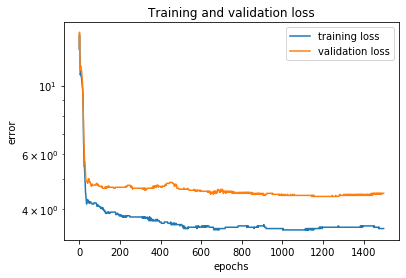

In [16]:
# plots 
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
# axis label
plt.xlabel('epochs')
plt.ylabel('error')
# title
plt.title('Training and validation loss')
#plt.autoscale(axis='x', tight=True)
plt.yscale('log', basey=10)
plt.legend()
plt.savefig(path + 'training_validation_loss.png', dpi=300)
plt.show()

In [17]:
epoch = validation_loss.index(min(validation_loss))
print('epoch for minimum validation loss =', epoch)

epoch for minimum validation loss = 1144


## Restore parameters

In [18]:
mlp2 = MLPClassifier(**parameters)
for i in range(epoch):
    iterate(X, y, Xval, yval, mlp2)

## Decision Region

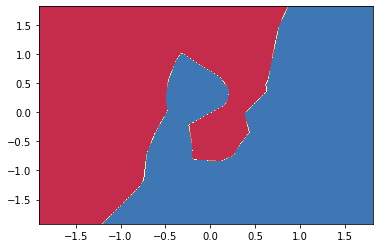

In [19]:
plot_decision_regions(X, mlp2)
plt.savefig(path + 'decision_region.png', dpi=300)

## Test set

In [20]:
print('Accuracy =', mlp.score(Xt, yt))

Accuracy = 0.879


## Different number of neurons

In [21]:
parameters['max_iter'] = 1000
neurons = [5, 25, 75, 100, 300, 1000, 5000]
mlp_array = []
for i in neurons:
    parameters['hidden_layer_sizes'] = (i)
    mlp_array.append(MLPClassifier(**parameters))

### Decision regions

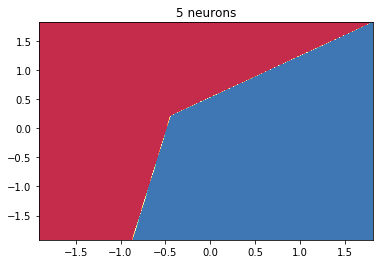

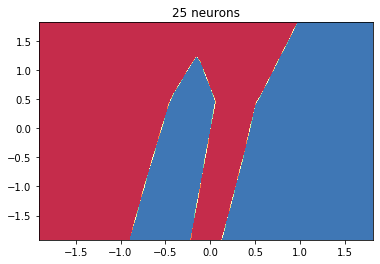

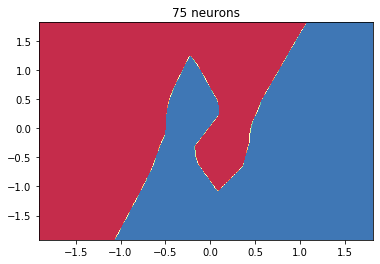

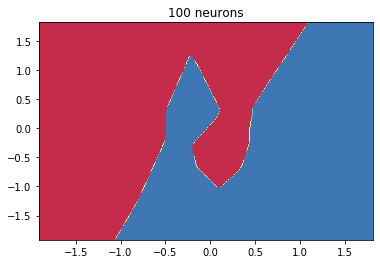

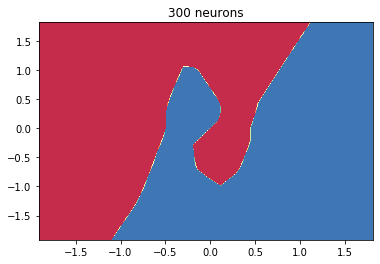

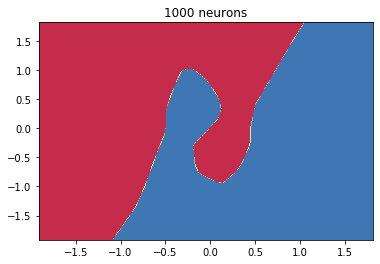

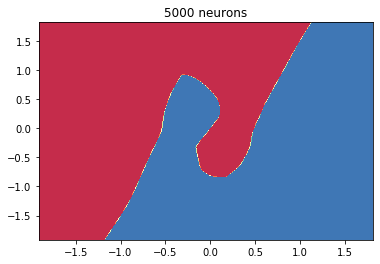

In [22]:
for i in range(len(mlp_array)):
    mlp_array[i].fit(X, y)
    plot_decision_regions(X, mlp_array[i])
    plt.title(str(neurons[i]) + ' neurons')
    plt.savefig(path + 'decision_regions_' + str(neurons[i]) + '.png', dpi=300)
    plt.show()

### Predict label and calculate probabilities

In [23]:
label = []
prob = []
for i in range(len(mlp_array)):
    label.append(mlp_array[i].predict(Xt))
    prob.append(mlp_array[i].predict_proba(Xt))

### Accuracy

In [24]:
for i in range(len(mlp_array)):
    print('Score for ', neurons[i], ' neurons = ', mlp_array[i].score(Xt, yt), sep='')

Score for 5 neurons = 0.733
Score for 25 neurons = 0.858
Score for 75 neurons = 0.87
Score for 100 neurons = 0.87
Score for 300 neurons = 0.872
Score for 1000 neurons = 0.877
Score for 5000 neurons = 0.86


### F1-score

In [25]:
for i in range(len(mlp_array)):
    f_score = f1_score(yt, label[i])
    print('F1-score for ', neurons[i], ' neurons = ', f_score, sep='')

F1-score for 5 neurons = 0.7618198037466548
F1-score for 25 neurons = 0.8580000000000001
F1-score for 75 neurons = 0.8678861788617886
F1-score for 100 neurons = 0.8662551440329218
F1-score for 300 neurons = 0.8696537678207739
F1-score for 1000 neurons = 0.8751269035532994
F1-score for 5000 neurons = 0.8580121703853956


### ROC curve

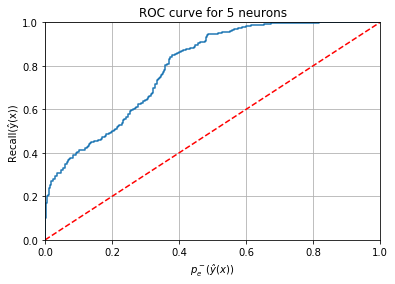

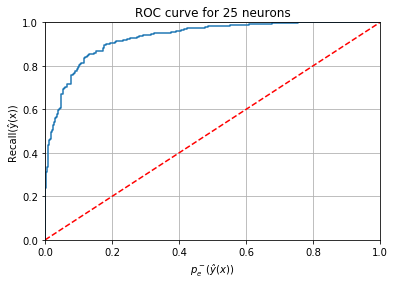

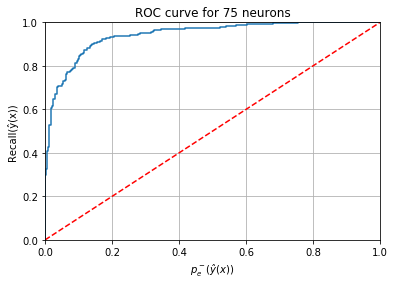

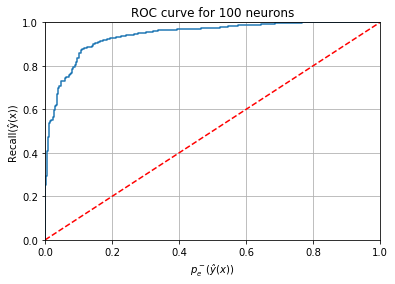

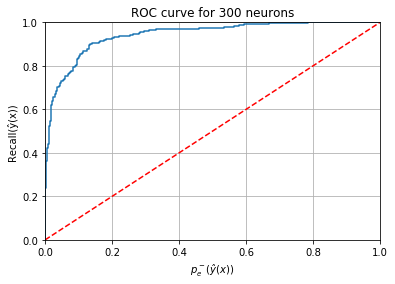

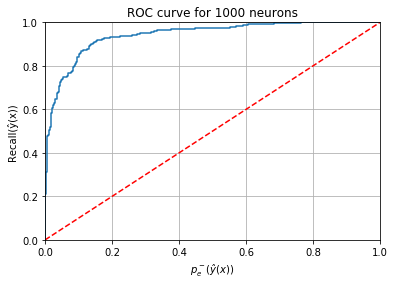

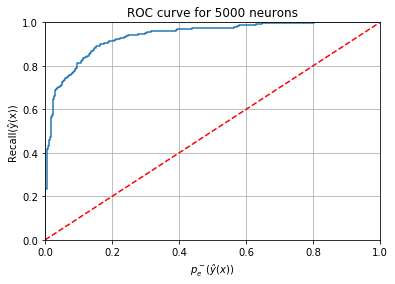

In [26]:
for i in range(len(mlp_array)):
    fpr, tpr, thresholds = roc_curve(yt, prob[i][:,1])
    # plot curves
    lin = np.linspace(0,1,1001)
    plt.plot(fpr, tpr)
    plt.plot(lin, lin, 'r--')
    # labels
    from matplotlib import rc
    plt.xlabel('$p_e^-(ŷ(x))$')
    plt.ylabel('Recall(ŷ(x))')
    # title
    plt.title('ROC curve for ' + str(neurons[i]) + ' neurons')
    # adjust plot
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.autoscale(axis='y', tight=True)
    plt.savefig(path + 'ROC_' + str(neurons[i]) + '.png', dpi=300)
    plt.show()

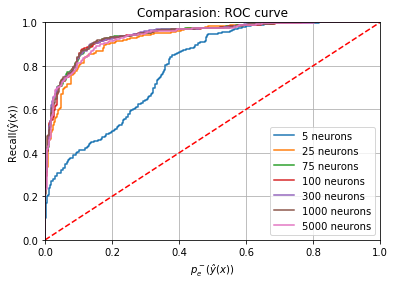

In [27]:
for i in range(len(mlp_array)):
    fpr, tpr, thresholds = roc_curve(yt, prob[i][:,1])
    # plot curves
    lin = np.linspace(0,1,1001)
    plt.plot(fpr, tpr, label=str(neurons[i]) + ' neurons')
plt.plot(lin, lin, 'r--')
# labels
from matplotlib import rc
plt.xlabel('$p_e^-(ŷ(x))$')
plt.ylabel('Recall(ŷ(x))')
# title
plt.title('Comparasion: ROC curve')
# adjust plot
plt.legend()
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.savefig(path + 'ROC_' + str(neurons[i]) + '.png', dpi=300)
plt.show()

### Area under the ROC curve

In [29]:
for i in range(len(mlp_array)):
    area = roc_auc_score(yt, prob[i][:,1])
    print('Area under the ROC curve for ', neurons[i], ' neurons = ', area, sep='')

Area under the ROC curve for 5 neurons = 0.7950791803167213
Area under the ROC curve for 25 neurons = 0.9304757219028874
Area under the ROC curve for 75 neurons = 0.9430477721910887
Area under the ROC curve for 100 neurons = 0.9415117660470642
Area under the ROC curve for 300 neurons = 0.9433997735990944
Area under the ROC curve for 1000 neurons = 0.9427197708790837
Area under the ROC curve for 5000 neurons = 0.9376317505270021
